Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Automated Machine Learning: Classification with Deployment

In this example we use the scikit learn's [digit dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) to showcase how you can use AutoML for a simple classification problem and deploy it to an Azure Container Instance (ACI).

Make sure you have executed the [configuration](../configuration.ipynb) before running this notebook.

In this notebook you will learn how to:
1. Create an experiment using an existing workspace.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute.
4. Explore the results.
5. Register the model.
6. Create a container image.
7. Create an Azure Container Instance (ACI) service.
8. Test the ACI service.


## Create an Experiment

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import json
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [5]:
from azureml.core.authentication import InteractiveLoginAuthentication

tenant_id = os.getenv("TENANT_ID", default="fee2180b-69b6-4afe-9f14-ccd70bd4c737")

my_auth = InteractiveLoginAuthentication(tenant_id=tenant_id)

ws = Workspace.from_config(auth=my_auth)

# choose a name for experiment
experiment_name = 'automl-local-classification'
# project folder
project_folder = './sample_projects/automl-local-classification'

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

Found the config file in: /home/nbuser/library/aml_config/config.json


,
Experiment Name,automl-local-classification
Location,southcentralus
Project Directory,./sample_projects/automl-local-classification
Resource Group,KC-leadershiptraining-rg
SDK version,1.0.2
Subscription ID,faa94835-ff02-41d2-a14a-bc0970e5b440
Workspace,LeadershipTrainingMLWS


## Diagnostics

Opt-in diagnostics for better experience, quality, and security of future releases.

In [6]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

## Configure AutoML

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|

In [7]:
digits = datasets.load_digits()
X_train = digits.data[10:,:]
y_train = digits.target[10:]

automl_config = AutoMLConfig(task = 'classification',
                             name = experiment_name,
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 20,
                             iterations = 10,
                             n_cross_validations = 2,
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train,
                             path = project_folder)

## Train the Models

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

In [8]:
local_run = experiment.submit(automl_config, show_output = True)

Parent Run ID: AutoML_3a813117-eaee-455c-a542-2186f2af5ce2
*******************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   RobustScaler LightGBM                          0:00:23       0.9988    0.9988
         1   StandardScalerWrapper KNN                      0:00:21       0.9987    0.9988
         2   StandardScalerWrapper KNN                      0:00:23       0.9980    0.9988
         3   MaxAbsScaler LightGBM                          0:00:25       0.9960    0.9988
         4   StandardScalerWrapper LightGBM 

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method on `automl_classifier` returns the best run and the fitted model for the last invocation. Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [9]:
best_run, fitted_model = local_run.get_output()

### Register the Fitted Model for Deployment
If neither `metric` nor `iteration` are specified in the `register_model` call, the iteration with the best primary metric is registered.

In [10]:
description = 'AutoML Model'
tags = None
model = local_run.register_model(description = description, tags = tags)
local_run.model_id # This will be written to the script file later in the notebook.

Registering model AutoML3a813117ebest


'AutoML3a813117ebest'

### Create Scoring Script

In [11]:
%%writefile score.py
import pickle
import json
import numpy
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = 'AutoML3a813117ebest') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

def run(rawdata):
    try:
        data = json.loads(rawdata)['data']
        data = numpy.array(data)
        result = model.predict(data)
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    return json.dumps({"result":result.tolist()})

Writing score.py


### Create a YAML File for the Environment

To ensure the fit results are consistent with the training results, the SDK dependency versions need to be the same as the environment that trains the model. Details about retrieving the versions can be found in notebook [12.auto-ml-retrieve-the-training-sdk-versions](12.auto-ml-retrieve-the-training-sdk-versions.ipynb).

In [12]:
experiment_name = 'automl-local-classification'

experiment = Experiment(ws, experiment_name)
ml_run = AutoMLRun(experiment = experiment, run_id = local_run.id)

In [13]:
dependencies = ml_run.get_run_sdk_dependencies(iteration = 7)

No issues found in the SDK package versions.


In [14]:
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	1.0.2
azureml-sdk	1.0.2
azureml-core	1.0.2


In [15]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'], pip_packages=['azureml-sdk[automl]'])

conda_env_file_name = 'myenv.yml'
myenv.save_to_file('.', conda_env_file_name)

'myenv.yml'

In [18]:
# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

script_file_name = 'score.py'

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run.model_id))

### Create a Container Image

In [19]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'area': "digits", 'type': "automl_classification"},
                                 description = "Image for automl classification sample")

image = Image.create(name = "automlsampleimage",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running............................................................
SucceededImage creation operation finished for image automlsampleimage:1, operation "Succeeded"


### Deploy the Image as a Web Service on Azure Container Instance

In [20]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "digits", 'type': "automl_classification"}, 
                                               description = 'sample service for Automl Classification')

In [21]:
from azureml.core.webservice import Webservice

aci_service_name = 'automl-sample-01'
print(aci_service_name)
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-sample-01
Creating service
Running....................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


### Delete a Web Service

In [ ]:
#aci_service.delete()

### Get Logs from a Deployed Web Service

In [ ]:
#aci_service.get_logs()

### Test a Web Service

5


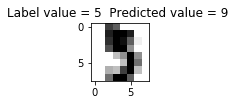

1


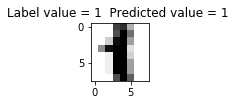

0


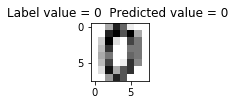

In [25]:
#Randomly select digits and test
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

for index in np.random.choice(len(y_test), 3, replace = False):
    print(index)
    test_sample = json.dumps({'data':X_test[index:index + 1].tolist()})
    predicted = aci_service.run(input_data = test_sample)
    label = y_test[index]
    predictedDict = json.loads(predicted)
    title = "Label value = %d  Predicted value = %s " % ( label,predictedDict['result'][0])
    fig = plt.figure(1, figsize = (1,1))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()